In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stacksample/Answers.csv
/kaggle/input/stacksample/Questions.csv
/kaggle/input/stacksample/Tags.csv


In [34]:
pd.options.display.max_colwidth =5000

df1 = pd.read_csv("/kaggle/input/stacksample/Questions.csv", encoding = 'ISO-8859-1')
df1 = df1.drop(["OwnerUserId", "CreationDate", "ClosedDate"], axis=1)
df2 = pd.read_csv("/kaggle/input/stacksample/Tags.csv", encoding = 'ISO-8859-1')

In [35]:
# Analysis- total number of questions - 1264216

df1["Id"].nunique()

1264216

In [36]:
# Cleaning

# Check duplicates and null values and drop rows accordingly

df2.shape  # Total 3750994 rows in DF2  
df2.isna().sum() # 1113 missing values in tags column
df2 = df2.dropna(subset = ['Tag'])  # drop rows where tags column has nan - 1113 rows
df2[df2.duplicated()]  # no duplicate rows in df2
df2.isna().sum()  # no null values in any column 


# df2 has labels. It has 1113 missing values in tags column. This means that there are many questions for which
#   there are no tags identified. We can remove the rows from df2 which do not have value for tags.

df1[df1.duplicated()]  # no duplicate rows in df1 overall
df1[df1.duplicated(['Id'])]  # no duplicate Question ID
df1[df1.duplicated(['Body', 'Title'])]  # same values for body and title - remove all such occurences in below line
df1.drop_duplicates(subset=['Body', 'Title'], keep=False, inplace=True)
df1.drop_duplicates(subset=['Body'], keep='last', inplace=True)  # remove rows where body is duplicate
df1.isna().sum()  # no null values

Id       0
Score    0
Title    0
Body     0
dtype: int64

In [37]:
# Cleaning

!pip install contractions

from bs4 import BeautifulSoup
import warnings
import string
import re
import contractions


warnings.filterwarnings("ignore")

def cleanup_tags(s):
    soup = BeautifulSoup(s, 'html.parser')    
    for tag in soup.find_all("code"):
        (tag.decompose())
    return soup.get_text(' ', strip=True)

def cleanup_language(s):
    s = s.str.lower()
    return s

def contractions_f(s):
    s = contractions.fix(s)
    return s

# df11 = df1[df1["Id"] < 100000]  # .isin([80, 90, 180, 120])] # Sampling Step has to be removed before training model.
df11["Body"] = (df11["Body"].apply(lambda x: cleanup_tags(x)))
df11["Body"]=df11['Body'].apply(lambda x: contractions_f(x))
df11["Title"]=df11['Title'].apply(lambda x: contractions_f(x))
df11[["Body", "Title"]] = df11[["Body", "Title"]].apply(cleanup_language)
df11 = pd.merge(left=df11, right=df2, left_on='Id', right_on='Id')  # join the datasets

In [38]:
# Analysis
# Lets see total number of labels in dataset. This is to get an idea as in how many labels we will group together
#   as one. This is because we will only use top 100 labels for our problem and rest will be called  "others"
Total_questions_in_dataset = (df11["Id"].nunique())
Total_labels_in_dataset = (df11["Tag"].nunique())
print(Total_labels_in_dataset, Total_questions_in_dataset)

# total labels in dataset is 1131 and total questions in dataset is 1191

1131 1191


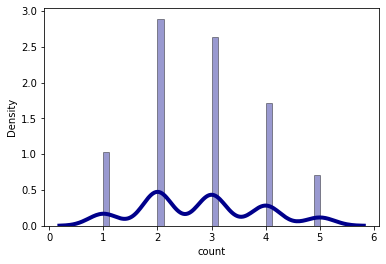

In [39]:
# Analysis
import seaborn as sns
from matplotlib import pyplot as plt

# lets see distribution of number of tags per question 

df11_analysis2 = df11.groupby(["Id", "Body"])["Body"].agg(['count']).sort_values(by='count',ascending = False)# .head(1000)

# Check distribution of target var
sns.distplot(df11_analysis2['count'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});

# We can see from density plot that most of the questions are having 2 or 3 tags

<AxesSubplot:ylabel='Tag'>

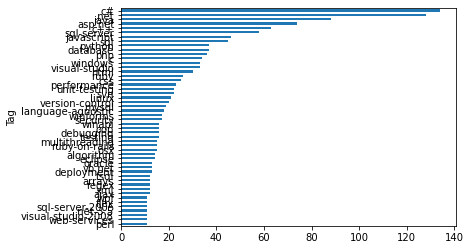

In [40]:
# Analysis
# check the top 100 labels based on the questions these labels are tagged as of now. In multi label
#   classification, we can't have infinite labels. Hence, in order to limit the number of labels, we analyze.
pd.set_option('display.max_rows', None)

df_analysis1 = df11.groupby(["Tag"])['Tag'].agg('count').sort_values(ascending = False).head(50)
df_analysis1.sort_values(ascending=True).plot(kind = 'barh')

{'10|0.01': 48.61, '20|0.02': 63.39, '30|0.03': 71.2, '40|0.04': 75.15, '50|0.04': 79.51, '60|0.05': 82.28, '70|0.06': 83.8, '80|0.07': 85.39, '90|0.08': 86.4, '100|0.09': 87.24, '110|0.1': 88.08, '120|0.11': 89.0, '130|0.11': 89.76, '140|0.12': 90.68}


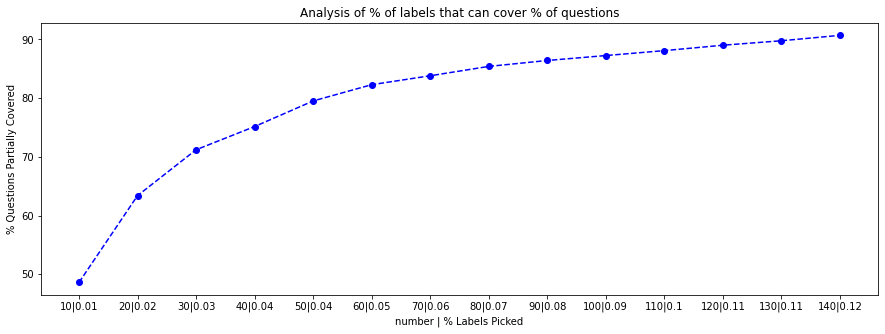

In [41]:
# Analysis 
import matplotlib.pylab as plt
# count of tags which will cover so and so count of questions
# percent of tags that will cover percent of questions

# top 100 labels cover how many questions from total dataset?

top_label_count_to_percent_question_covered = {}
for i in range(10, 150, 10):
    df_analysis1 = df11.groupby(["Tag"])['Tag'].agg('count').sort_values(ascending = False).head(i)
    df_analysis1.sort_values(ascending=True)

    df_analysis3 = df11[df11["Tag"].isin(df_analysis1.index.values.tolist())]
    
    top_label_count_to_percent_question_covered[str(i) + "|" + str(round(i/Total_labels_in_dataset, 2))] = round((df_analysis3["Id"].nunique()/Total_questions_in_dataset) * 100, 2)

print(top_label_count_to_percent_question_covered)

def plot_dictionary_k_v(d):
    lists = (d.items()) # sorted by key, return a list of tuples

    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.figure(figsize=(15, 5))
    plt.title("Analysis of % of labels that can cover % of questions")
    plt.xlabel("number | % Labels Picked")
    plt.ylabel("% Questions Partially Covered")
    plt.plot(x, y, linestyle='--', marker='o', color='b', label='line with marker')
    plt.show()

plot_dictionary_k_v(top_label_count_to_percent_question_covered)
# example inferences
# from graph below, we derive that we pick 80 (0.07% of labels) labels which will cover 85.39% of questions

In [42]:
# Cleaning
# Let's pick top 80 labels by frequency - analysis done in previous cell. We will only predict these top 80
#   labels and our data will also have only these labels. 

df_analysis1 = df11.groupby(["Tag"])['Tag'].agg('count').sort_values(ascending = False).head(80)
df11 = df11[df11["Tag"].isin(df_analysis1.index.values.tolist())]  # remove question-tag pair where tag is not in top 80

Top_tags = df11['Tag'].values

In [43]:
# Analysis
# Checking if there is any 2 word tag. If thats the case, we need to manage the same while removing punctuation (dont remove C# for example)
for i in Top_tags:
    if (len(i.split(' '))) > 1:
        print('more than one word in a tag')  # there is no 2 word tag. all have a hyphen in between

In [44]:
# Cleaning
from nltk.tokenize import ToktokTokenizer
token=ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'


def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in Top_tags:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

df11["Body"] = df11["Body"].apply(clean_punct)
df11["Title"] = df11["Title"].apply(clean_punct)

In [45]:
# Cleaning

df11 = df11.astype({'Title': 'string', 'Body': 'string', 'Tag': 'string'})
df11.dtypes

Id        int64
Score     int64
Title    string
Body     string
Tag      string
dtype: object

In [46]:
# Analysis
# Check the meaning of score by analyzing the data for lower and higher scores
df11[df11["Score"] ==0]

# I tried with multiple values of score above 0 and below 0(-1 and -2). I did not find any major difference that
#   would make a high score question stand out from crowd. Hence, dropping Score column

df11.drop(["Score"],axis=1, inplace = True)

In [47]:
# Cleaning
# Flatten the tags in one row per ID
df11 = df11.groupby(["Id", "Title", "Body"])["Tag"].apply(lambda x: ' '.join(x)).reset_index()

In [48]:
# Cleanup on language - Stop word and Lemmatization
import spacy
nlp = spacy.load("en_core_web_sm")

def clean_sw_lemma(text):
    text = " ".join(token.lemma_ for token in nlp(text) if not token.is_stop and token.is_alpha)
    return text

df11["Body"] = df11["Body"].apply(clean_sw_lemma)
df11["Title"] = df11["Title"].apply(clean_sw_lemma)

In [50]:
# Clean
df11.drop(["Id"], axis=1, inplace=True)

In [51]:
# Cleaning

# convert tag to format required by multilabel binarizer
df11['Tag'] = df11['Tag'].apply(lambda x: (x.split(' ')))

In [52]:
# Feature Generation

from sklearn.model_selection import train_test_split

X = df11.drop('Tag', axis=1)
y = df11['Tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # Do 80/20 split

In [53]:
# Feature generation - y_transformed
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
multilabel_binarizer = MultiLabelBinarizer()

multilabel_binarizer.fit(y_train)  # The idea is to convert y into an array of length same as max number of 
#   labels. The array has val 1 if a particular label is present else 0
y_train_tf = multilabel_binarizer.transform(y_train)
y_test_tf = multilabel_binarizer.transform(y_test)

In [54]:
# Feature generation - X_transformed
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer

tfidf_transformer = FeatureUnion([
                ('Title_tfidf', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['Title'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(analyzer = 'word',encoding = 'utf-8'))])),
                ('Body_tfidf', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['Body'], 
                                                  validate=False)),
                            ('tfidf', 
                              TfidfVectorizer(analyzer = 'word',encoding = 'utf-8', max_features=1000))]))]) 

tfidf_transformer.fit(X_train)

title_vocab = tfidf_transformer.transformer_list[0][1].steps[1][1].get_feature_names() 
body_vocab = tfidf_transformer.transformer_list[1][1].steps[1][1].get_feature_names()
vocab = title_vocab + body_vocab
print(len(vocab)) # For reference - len of vocab is hstack of TFIDF of body (1000 max) and TFIDF of title (no max specified)

X_train_tf = tfidf_transformer.transform(X_train)
X_test_tf = tfidf_transformer.transform(X_test)

2509


In [55]:
# inference techniques for multi label 

# Binary Relevance - multi label is assumed as combination of multiple independent binary classifiers

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, hamming_loss

classifier = BinaryRelevance(GaussianNB())
# train
classifier.fit(X_train_tf, y_train_tf)
# predict
predictions = classifier.predict(X_test_tf)
# accuracy
print("Accuracy = ",accuracy_score(y_test_tf,predictions))
print("Hamming_loss = ",hamming_loss(y_test_tf,predictions))


Accuracy =  0.024509803921568627
Hamming_loss =  0.020955882352941175


In [56]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

# Classifier Chain - Use one target feature for prediction. Post that take think of this target as a feature and 
#   use the next target as predictor variable. This forms a chain of classifiers.

classifier = ClassifierChain(GaussianNB())  # also tried LogisticRegression instead of NB
# train
classifier.fit(X_train_tf, y_train_tf)
# predict
predictions = classifier.predict(X_test_tf)
# accuracy
print("Accuracy = ",accuracy_score(y_test_tf,predictions))
print("Hamming_loss = ",hamming_loss(y_test_tf,predictions))


Accuracy =  0.024509803921568627
Hamming_loss =  0.0210171568627451


In [57]:
from skmultilearn.problem_transform import LabelPowerset

# Label powerset treats a combination of all predictor variables as one class. 

classifier = LabelPowerset(GaussianNB())  # also tried LogisticRegression instead of NB
# train
classifier.fit(X_train_tf, y_train_tf)
# predict
predictions = classifier.predict(X_test_tf)
# accuracy
print("Accuracy = ",accuracy_score(y_test_tf,predictions))
print("Hamming_loss = ",hamming_loss(y_test_tf,predictions))


Accuracy =  0.10294117647058823
Hamming_loss =  0.027512254901960784


In [65]:
from sklearn.multiclass import OneVsRestClassifier
# This needs to be explored further as it is generally used for multi class classification. Not sure how 
#   is it used in a multi label classification. 

lr = LogisticRegression()
mn = MultinomialNB()

for classifier in [lr, mn]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train_tf, y_train_tf)
    predictions = clf.predict(X_test_tf)
    print("{}".format(clf))
    print("Accuracy = ",accuracy_score(y_test_tf,predictions))
    print("Hamming_loss = ",hamming_loss(y_test_tf,predictions))
    print("\n")

OneVsRestClassifier(estimator=LogisticRegression())
Accuracy =  0.004901960784313725
Hamming_loss =  0.01997549019607843


OneVsRestClassifier(estimator=MultinomialNB())
Accuracy =  0.0
Hamming_loss =  0.020159313725490197


